In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel

import os
import json
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

# 基本参数
MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-5
WEIGHT_DECAY = 0.01
SAVE_PATH = "clip_finetuned_with_prompt.pth"

# 模型加载与解冻
def prepare_model(model_name=MODEL_NAME, device=DEVICE):
    model = CLIPModel.from_pretrained(model_name).to(device)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.vision_model.named_parameters():
        if 'encoder.layers.11' in name or 'post_layernorm' in name:
            param.requires_grad = True
    return model

model = prepare_model()
model.logit_scale.requires_grad_(True)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

### sampling and merging

In [20]:
class RoadSignDataSplitter:
    def __init__(
        self,
        json_paths: Dict[str, str],      # 国家到json标注文件路径
        image_dirs: Dict[str, str],      # 国家到图片文件夹路径
        train_ratio: float = 0.6,
        val_ratio: float = 0.2,
        test_ratio: float = 0.2,
        seed: int = 42
    ):
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "各集划分比例之和必须为1"
        self.json_paths = json_paths
        self.image_dirs = image_dirs
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.seed = seed
        self.all_labels_set = set()
        self.train_samples = []
        self.val_samples = []
        self.test_samples = []
        self.label2id = {}
        self.id2label = {}
        self.all_labels = []

    def sample_and_split(self):
        random.seed(self.seed)
        train_samples, val_samples, test_samples = [], [], []
        all_labels_set = set()

        for country, json_path in self.json_paths.items():
            with open(json_path, 'r', encoding='utf-8') as f:
                gt = json.load(f)

            country_samples = {}
            for fname, label in gt.items():
                new_fname = f"{country}_{fname}"
                country_samples[new_fname] = {
                    "label": label,
                    "path": os.path.join(self.image_dirs[country], fname)
                }
                all_labels_set.add(label)

            # 按类别分桶再划分
            per_class = defaultdict(list)
            for fname, meta in country_samples.items():
                per_class[meta["label"]].append((fname, meta["path"]))

            for label, items in per_class.items():
                random.shuffle(items)
                n = len(items)
                n_train = int(self.train_ratio * n)
                n_val = int(self.val_ratio * n)
                n_test = n - n_train - n_val
                train_samples += [(f, p, label) for f, p in items[:n_train]]
                val_samples   += [(f, p, label) for f, p in items[n_train:n_train+n_val]]
                test_samples  += [(f, p, label) for f, p in items[n_train+n_val:]]

        # 建立label映射
        all_labels = sorted(all_labels_set)
        label2id = {label: idx for idx, label in enumerate(all_labels)}
        id2label = {idx: label for label, idx in label2id.items()}

        # 转换为label_id
        train_samples = [(f, p, label2id[lbl]) for f, p, lbl in train_samples]
        val_samples   = [(f, p, label2id[lbl]) for f, p, lbl in val_samples]
        test_samples  = [(f, p, label2id[lbl]) for f, p, lbl in test_samples]

        # 保存到对象属性
        self.all_labels_set = all_labels_set
        self.all_labels = all_labels
        self.label2id = label2id
        self.id2label = id2label
        self.train_samples = train_samples
        self.val_samples = val_samples
        self.test_samples = test_samples

    def get_split(self, split: str = 'train') -> List[Tuple[str, str, int]]:
        if split == 'train':
            return self.train_samples
        elif split == 'val':
            return self.val_samples
        elif split == 'test':
            return self.test_samples
        else:
            raise ValueError("split must be one of ['train', 'val', 'test']")

    def save_label_map(self, path: str):
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(self.label2id, f, ensure_ascii=False, indent=2)

json_paths = {
    'cn': 'ground_truth_cn.json',
    'de': 'ground_truth_de.json',
    # 'in': 'ground_truth_in.json',
}
image_dirs = {
    'cn': 'dataset_cn',
    'de': 'dataset_de',
    # 'in': 'dataset_in',
}
splitter = RoadSignDataSplitter(json_paths, image_dirs, train_ratio=0.5, val_ratio=0.3, test_ratio=0.2, seed=123)
splitter.sample_and_split()

### load dataset

In [21]:
class RoadSignSampleDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        _, img_path, label_id = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        return img, label_id

def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

# 数据集
train_dataset = RoadSignSampleDataset(splitter.get_split('train'))
val_dataset   = RoadSignSampleDataset(splitter.get_split('val'))
test_dataset  = RoadSignSampleDataset(splitter.get_split('test'))

# 加载器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, collate_fn=collate_fn)

### load prompts

In [22]:
with open("prompt_cn.json", "r", encoding="utf-8") as f:
    prompts_cn = json.load(f)
with open("prompt_de.json", "r", encoding="utf-8") as f:
    prompts_de = json.load(f)
with open("prompt_in.json", "r", encoding="utf-8") as f:
    prompts_in = json.load(f)

# 构建完整的 prompt_variations 字典
prompt_variations = {
    'cn': [prompts_cn[label] for label in splitter.all_labels],
    'de': [prompts_de[label] for label in splitter.all_labels],
    # 'in': [prompts_in[label] for label in splitter.all_labels],
}

### track training

In [23]:
class TrainingTracker:
    def __init__(self):
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []

    def record(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)

    def plot(self):
        fig, ax1 = plt.subplots(figsize=(8, 5))

        # 左轴：Loss
        ax1.plot(self.train_loss, label='Train Loss', color='tab:blue', linestyle='-')
        ax1.plot(self.val_loss, label='Val Loss', color='tab:blue', linestyle='--')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # 右轴：Accuracy
        ax2 = ax1.twinx()
        ax2.plot(self.train_acc, label='Train Acc', color='tab:orange', linestyle='-')
        ax2.plot(self.val_acc, label='Val Acc', color='tab:orange', linestyle='--')
        ax2.set_ylabel("Accuracy", color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # 图例
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

        plt.title("Training History")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def to_dataframe(self):
        data = {
            'Train Loss': self.train_loss,
            'Train Acc': self.train_acc,
            'Val Loss': self.val_loss,
            'Val Acc': self.val_acc
        }
        return pd.DataFrame(data)



### loss, features, evaluation function

In [24]:
def clip_prompt_classification_loss(
    image_features: torch.Tensor,
    text_features: torch.Tensor,
    target_indices: torch.Tensor
) -> torch.Tensor:
    # 归一化向量
    image_features = nn.functional.normalize(image_features, dim=-1)
    text_features = nn.functional.normalize(text_features, dim=-1)

    # 相似度得分：[B, C]
    logits = image_features @ text_features.T

    # 分类损失
    return nn.CrossEntropyLoss()(logits, target_indices)

def get_class_text_features(model, processor, prompt_variations, categories, domain_keys, device=DEVICE):
    """每类随机采样一个 prompt 得到类别 embedding"""
    category_prompts = []
    for i in range(len(categories)):
        merged_prompts = []
        for d in domain_keys:
            merged_prompts += prompt_variations[d][i]
        prompt = random.choice(merged_prompts)
        category_prompts.append(prompt)
    text_inputs = processor(text=category_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        class_text_features = model.get_text_features(**text_inputs)
        class_text_features = nn.functional.normalize(class_text_features, dim=-1)
    return class_text_features

def get_class_text_features_avg(model, processor, prompt_variations, categories, domain_keys, device=DEVICE):
    """每类所有 prompt embedding 平均化，得到类别 embedding"""
    all_prompts = []
    prompt_to_cat = []
    for i in range(len(categories)):
        merged_prompts = []
        for d in domain_keys:
            merged_prompts += prompt_variations[d][i]
        all_prompts.extend(merged_prompts)
        prompt_to_cat.extend([i] * len(merged_prompts))

    text_inputs = processor(text=all_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        feats = model.get_text_features(**text_inputs)
        feats = nn.functional.normalize(feats, dim=-1)
    # 平均
    C = len(categories)
    class_feats = torch.zeros(C, feats.shape[1], device=feats.device)
    counts = torch.zeros(C, device=feats.device)
    for i, cat_id in enumerate(prompt_to_cat):
        class_feats[cat_id] += feats[i]
        counts[cat_id] += 1
    class_feats = class_feats / counts.unsqueeze(1)
    class_feats = nn.functional.normalize(class_feats, dim=-1)
    return class_feats

def evaluate(model, dataloader, processor, prompt_variations, categories, domain_keys, device=DEVICE):
    model.eval()
    class_text_features = get_class_text_features_avg(
        model, processor, prompt_variations, categories, domain_keys, device
    )
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, category_indices in dataloader:
            image_inputs = processor(images=list(images), return_tensors="pt").to(device)
            category_indices = category_indices.to(device)
            image_features = model.get_image_features(**image_inputs)
            loss = clip_prompt_classification_loss(image_features, class_text_features, category_indices)
            total_loss += loss.item()
            logits = image_features @ class_text_features.T
            preds = logits.argmax(dim=1)
            correct += (preds == category_indices).sum().item()
            total += len(images)

    avg_loss = total_loss / len(dataloader)
    acc = correct / total
    return avg_loss, acc

In [25]:
def train_model(
    model, dataloader, processor, prompt_variations, categories, domain_keys,
    val_loader=None, epochs=EPOCHS, save_path=SAVE_PATH, device=DEVICE
):
    tracker = TrainingTracker()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR, weight_decay=WEIGHT_DECAY
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct, train_total = 0, 0

        # 一般只需每轮重新计算一次类别 embedding（prompt embedding如果随batch变化则要每batch更新）
        class_text_features = get_class_text_features_avg(
            model, processor, prompt_variations, categories, domain_keys, device
        )

        for images, category_indices in dataloader:
            image_inputs = processor(images=list(images), return_tensors="pt").to(device)
            category_indices = category_indices.to(device)

            image_features = model.get_image_features(**image_inputs)
            loss = clip_prompt_classification_loss(image_features, class_text_features, category_indices)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            with torch.no_grad():
                logits = image_features @ class_text_features.T
                preds = logits.argmax(dim=1)
                train_correct += (preds == category_indices).sum().item()
                train_total += len(images)

        avg_train_loss = total_loss / len(dataloader)
        train_acc = train_correct / train_total

        # ========== 验证 ========== #
        val_loss, val_acc = evaluate(
            model, val_loader, processor, prompt_variations, categories, domain_keys, device
        )

        tracker.record(avg_train_loss, train_acc, val_loss, val_acc)
        print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    torch.save({
        'model_state_dict': model.state_dict(),
        'categories': categories,
    }, save_path)

    print(f"Model saved to {save_path}")
    return tracker


### Train with 1 dataset

In [26]:
history = train_model(
    model, train_loader, processor,
    prompt_variations=prompt_variations,
    categories=splitter.all_labels,
    domain_keys=['cn', 'de'],
    val_loader=val_loader,
    epochs=20
)

c:\Users\J4vix\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Epoch 1/20] Train Loss: 3.3588 | Train Acc: 46.84% | Val Loss: 3.3399 | Val Acc: 57.99%
[Epoch 2/20] Train Loss: 3.3249 | Train Acc: 55.79% | Val Loss: 3.3078 | Val Acc: 61.19%
[Epoch 3/20] Train Loss: 3.2947 | Train Acc: 67.11% | Val Loss: 3.2816 | Val Acc: 67.58%
[Epoch 4/20] Train Loss: 3.2706 | Train Acc: 73.16% | Val Loss: 3.2617 | Val Acc: 69.86%
[Epoch 5/20] Train Loss: 3.2520 | Train Acc: 75.79% | Val Loss: 3.2467 | Val Acc: 72.15%
[Epoch 6/20] Train Loss: 3.2377 | Train Acc: 75.79% | Val Loss: 3.2345 | Val Acc: 70.78%
[Epoch 7/20] Train Loss: 3.2258 | Train Acc: 76.58% | Val Loss: 3.2243 | Val Acc: 73.06%
[Epoch 8/20] Train Loss: 3.2153 | Train Acc: 76.32% | Val Loss: 3.2155 | Val Acc: 73.97%
[Epoch 9/20] Train Loss: 3.2063 | Train Acc: 77.37% | Val Loss: 3.2075 | Val Acc: 73.52%
[Epoch 10/20] Train Loss: 3.1980 | Train Acc: 79.74% | Val Loss: 3.2006 | Val Acc: 75.34%
[Epoch 11/20] Train Loss: 3.1907 | Train Acc: 80.00% | Val Loss: 3.1942 | Val Acc: 74.43%
[Epoch 12/20] Train

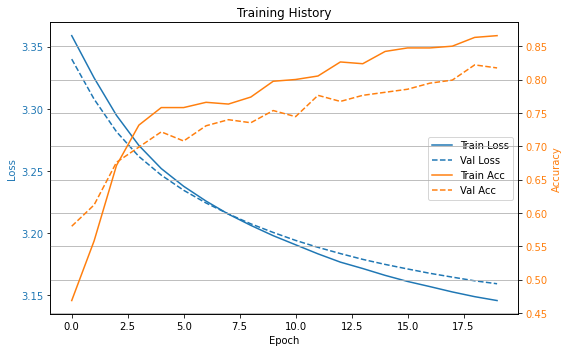

In [27]:
history.plot()

In [28]:
test_loss, test_acc = evaluate(
    model, test_loader, processor, prompt_variations, categories=splitter.all_labels, domain_keys=['cn', 'de'], device=DEVICE
)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}")

Test Loss: 3.1610 | Test Acc: 83.15%
